In [1]:
import sys; sys.path.append('../..')
from heatwave import ERA, Country, utils

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os

# Data Sources

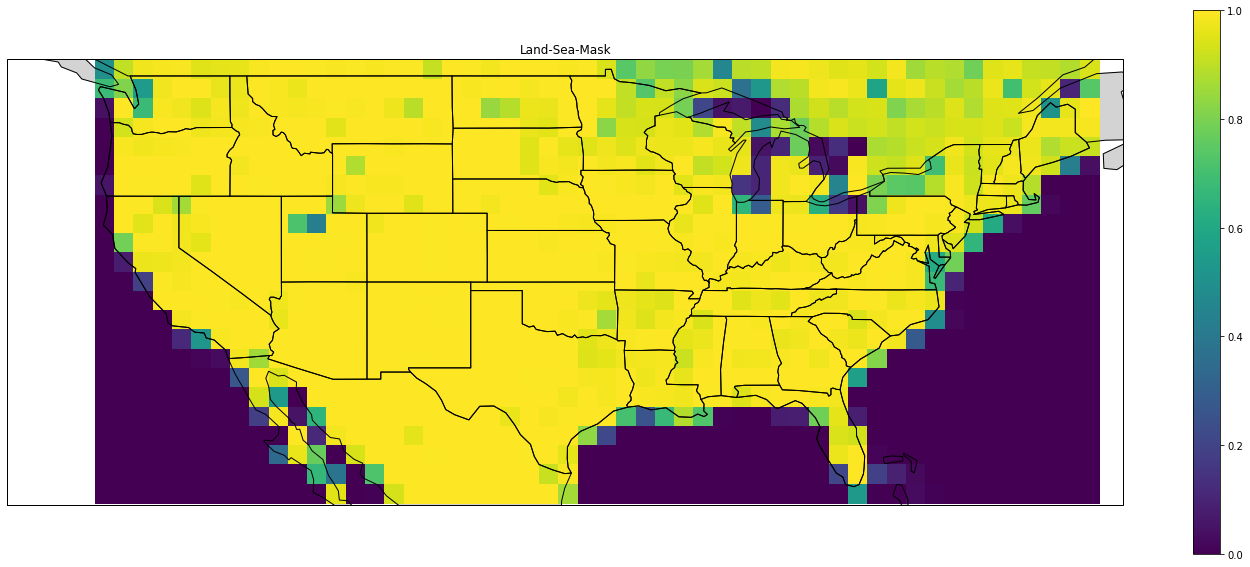

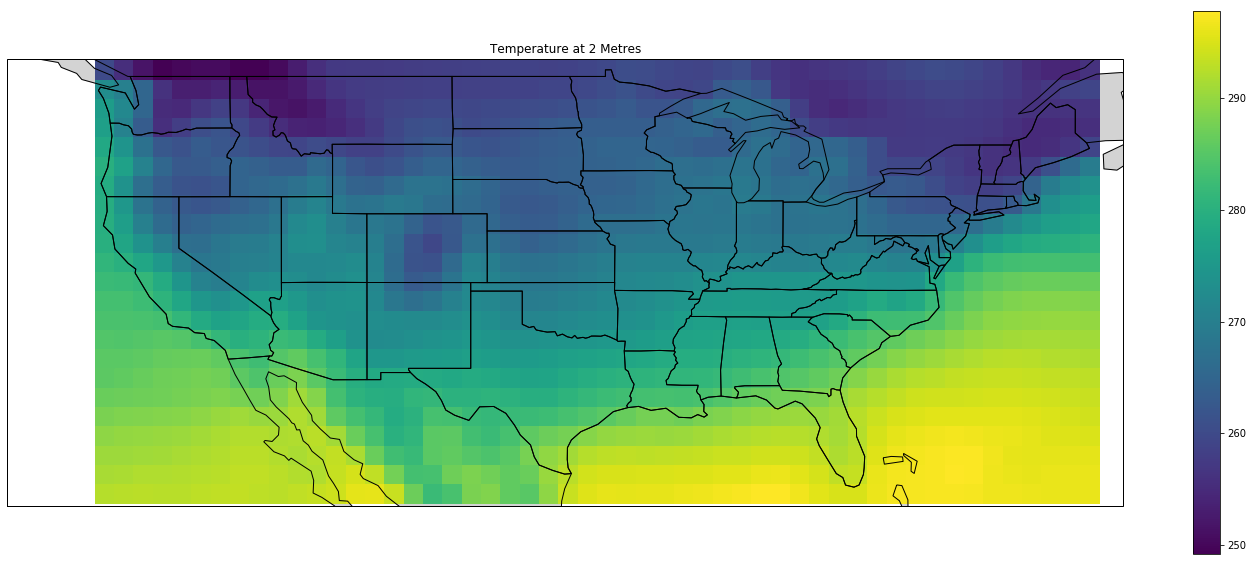

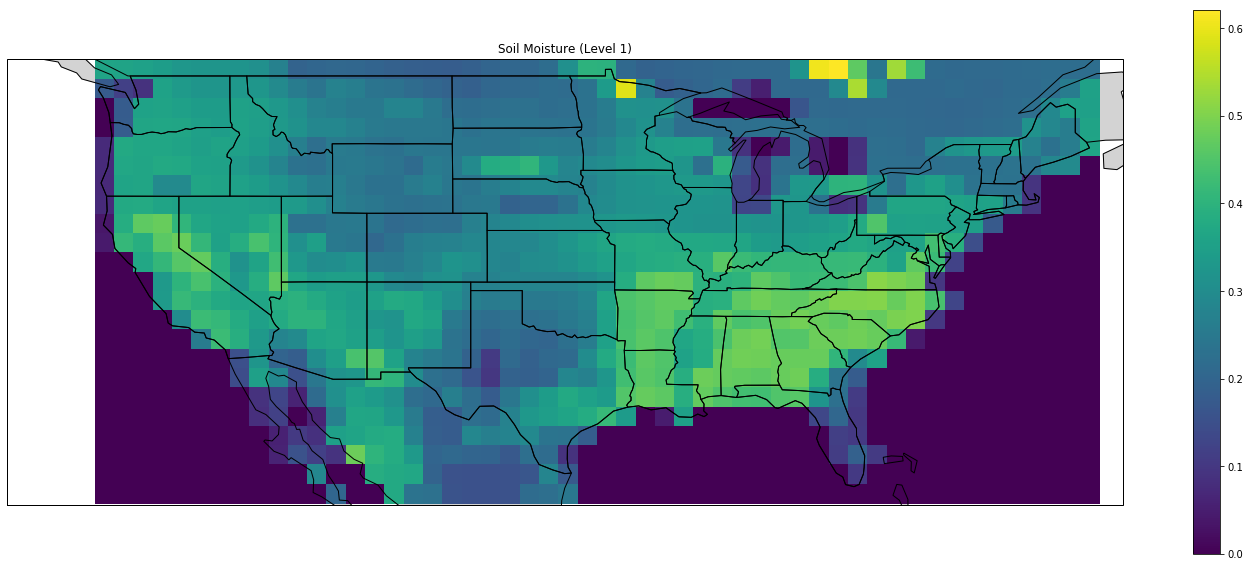

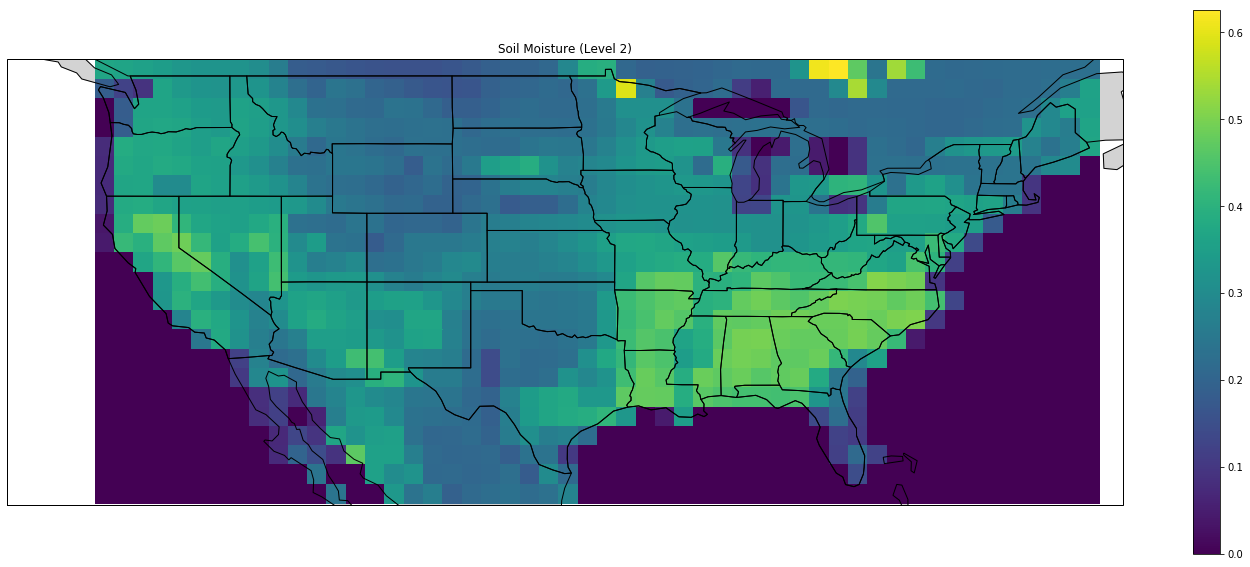

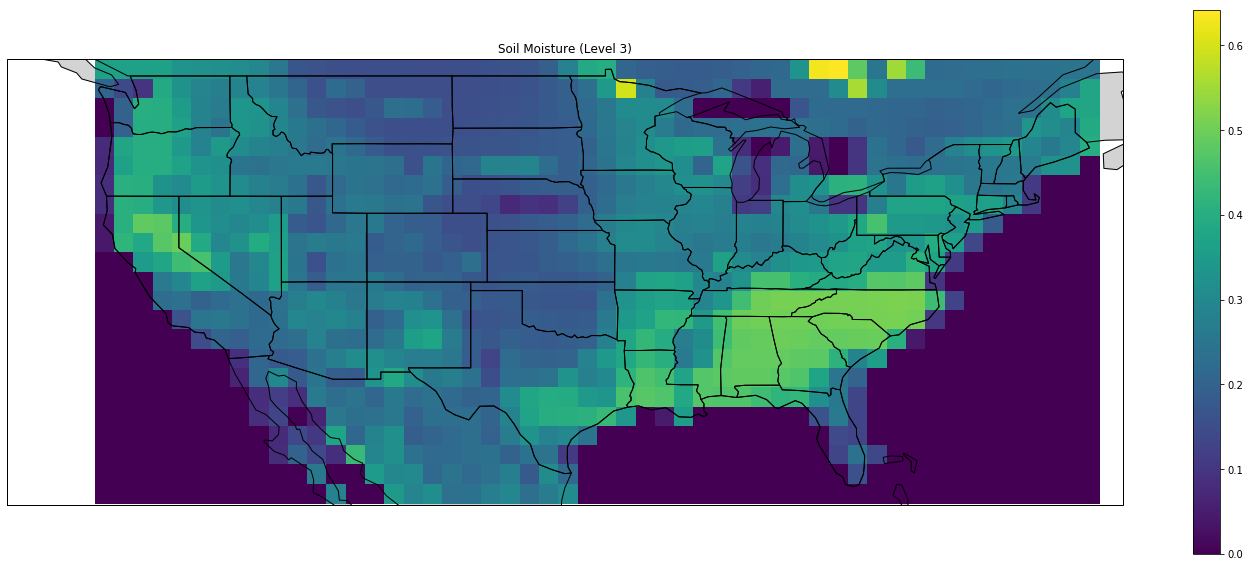

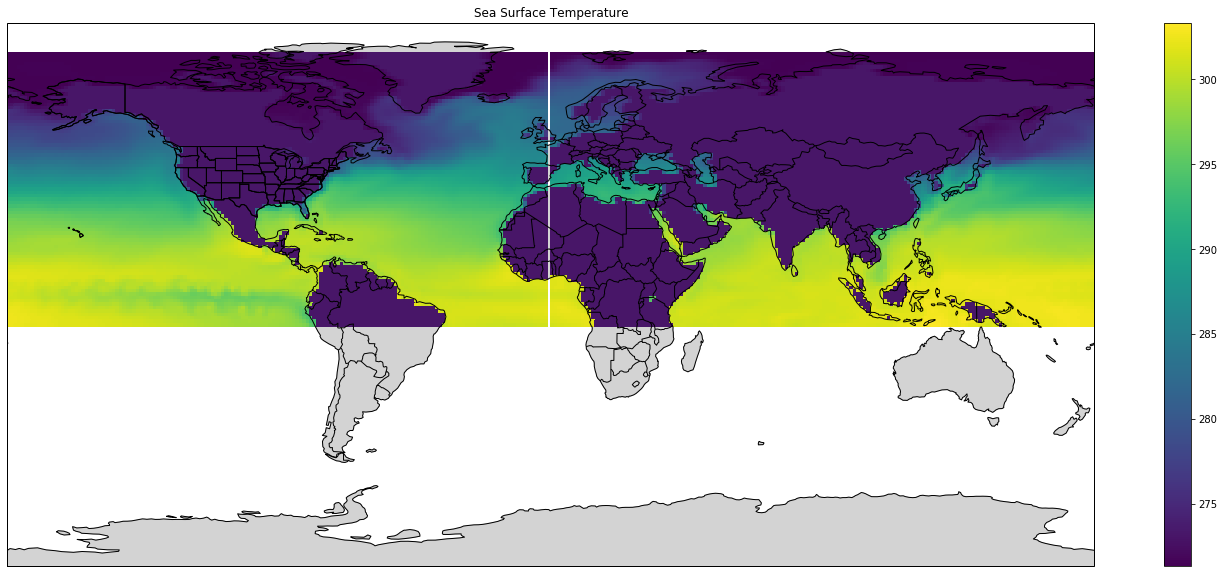

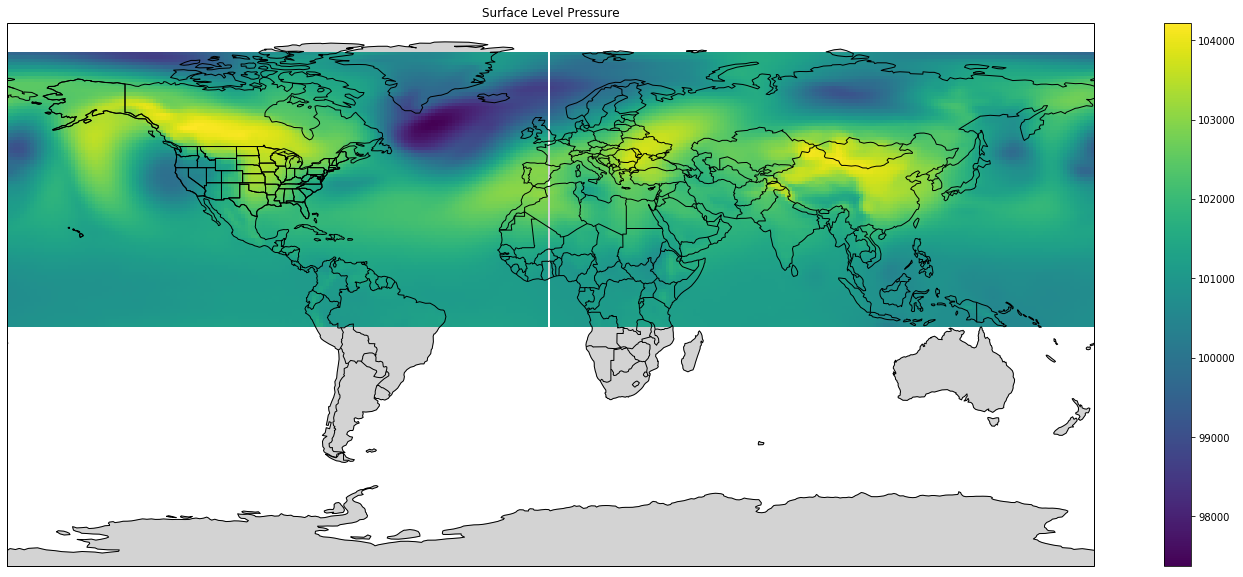

In [168]:
ROOT = '/Volumes/Samsung_T5/Thesis'

PLOT = True
TIME = [0] if PLOT else None

SOURCE = 'ECE'

# ERA-Interim
if SOURCE == 'ERA':
    ERA_US_075 = slice(54, 88), slice(313, 392)
    ERA_NORTH = slice(4, 41), None
    LSM = ERA(os.path.join(ROOT, 'ERA/landseamask_0.75deg.nc'), 'lsm', index=[TIME, *ERA_US_075])
    T2M = ERA(os.path.join(ROOT, 'ERA/t2m_1979-2017_1_12_daily_0.75deg.nc'), 't2m', index=[TIME, *ERA_US_075])
    SM1 = ERA(os.path.join(ROOT, 'ERA/sm1_1979-2017_1_12_daily_0.75deg.nc'), 'swvl1', index=[TIME, *ERA_US_075])
    SM2 = ERA(os.path.join(ROOT, 'ERA/sm2_1979-2017_1_12_daily_0.75deg.nc'), 'swvl2', index=[TIME, *ERA_US_075])
    SM3 = ERA(os.path.join(ROOT, 'ERA/sm3_1979-2017_2jan_31okt_dt-1days_0.75deg.nc'), 'swvl3', index=[TIME, *ERA_US_075])
    SST = ERA(os.path.join(ROOT, 'ERA/sst_1979-2017_1_12_daily_2.5deg.nc'), 'sst', index=[TIME, *ERA_NORTH])
    SLP = ERA(os.path.join(ROOT, 'ERA/SLP_1979-2017_1jan_31dec_dt-1days_2.5deg.nc'), 'msl', index=[TIME, *ERA_NORTH])

# ERA-5
if SOURCE == 'ERA5':
    ERA5_T2M_US_025 = slice(42, 141), slice(21, 254)
    ERA5_SML_US_025 = slice(2, 101), slice(21, 254)
    LSM = ERA(os.path.join(ROOT, 'ERA5/landseamask_0.25deg.nc'), 'lsm', index=[TIME, slice(162, 261), slice(941, 1174)])
    T2M = ERA(os.path.join(ROOT, 'ERA5/t2mmax_US_1979-2018_1jan_31dec_daily_0.25deg.nc'), 't2m', index=[TIME, *ERA5_T2M_US_025])
    SM1 = ERA(os.path.join(ROOT, 'ERA5/sm_1_1979-2018_1jan_31dec_daily_0.25deg.nc'), 'swvl1', index=[TIME, *ERA5_SML_US_025])
    SM2 = ERA(os.path.join(ROOT, 'ERA5/sm_2_1979-2018_1jan_31dec_daily_0.25deg.nc'), 'swvl2', index=[TIME, *ERA5_SML_US_025])
    SM3 = ERA(os.path.join(ROOT, 'ERA5/sm_3_1979-2018_1jan_31dec_daily_0.25deg.nc'), 'swvl3', index=[TIME, *ERA5_SML_US_025])
    SST = ERA(os.path.join(ROOT, 'ERA5/sst_1979-2018_1jan_31dec_daily_2.5deg.nc'), 'sst', index=[TIME, slice(4, -4)])
    SLP = ERA(os.path.join(ROOT, 'ERA5/SLP_1979-2018_1jan_31dec_daily_2.5deg.nc'), 'msl', index=[TIME, slice(4, 40)])

# EC-Earth
if SOURCE == 'ECE':
    ECE_KWARGS = dict(longitude_key='lon', latitude_key='lat')
    ECE_US_25 = None, slice(2, -1)
    LSM = ERA(os.path.join(ROOT, 'EC-Earth/landseamask_2.5deg.nc'), 'lsm', index=[TIME, *ECE_US_25], **ECE_KWARGS)
    T2M = ERA(os.path.join(ROOT, 'EC-Earth/160/tas_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'tas', index=[TIME, *ECE_US_25], **ECE_KWARGS)
    SM1 = ERA(os.path.join(ROOT, 'EC-Earth/160/mrlsl1_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'mrlsl1', index=[TIME, *ECE_US_25], **ECE_KWARGS)
    SM2 = ERA(os.path.join(ROOT, 'EC-Earth/160/mrlsl2_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'mrlsl2', index=[TIME, *ECE_US_25], **ECE_KWARGS)
    SM3 = ERA(os.path.join(ROOT, 'EC-Earth/160/mrlsl3_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'mrlsl3', index=[TIME, *ECE_US_25], **ECE_KWARGS)
    SST = ERA(os.path.join(ROOT, 'EC-Earth/160/tos_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'tos', index=[TIME], **ECE_KWARGS)
    SLP = ERA(os.path.join(ROOT, 'EC-Earth/160/psl_d_ECEarth_PD_1start_10ens_lastyr.nc'), 'psl', index=[TIME], **ECE_KWARGS)


if PLOT:
    utils.plot_earth("US")
    plt.pcolormesh(LSM.longitude, LSM.latitude, LSM.data[0])
    plt.colorbar()
    plt.title("Land-Sea-Mask")
    plt.show()
    
    utils.plot_earth("US")
    plt.pcolormesh(T2M.longitude, T2M.latitude, T2M.data[0])
    plt.title("Temperature at 2 Metres")
    plt.colorbar()
    plt.show()

    utils.plot_earth("US")
    plt.pcolormesh(SM1.longitude, SM1.latitude, SM1.data[0])
    plt.title("Soil Moisture (Level 1)")
    plt.colorbar()
    plt.show()

    utils.plot_earth("US")
    plt.pcolormesh(SM2.longitude, SM2.latitude, SM2.data[0])
    plt.title("Soil Moisture (Level 2)")
    plt.colorbar()
    plt.show()

    utils.plot_earth("US")
    plt.pcolormesh(SM3.longitude, SM3.latitude, SM3.data[0])
    plt.title("Soil Moisture (Level 3)")
    plt.colorbar()
    plt.show()

    utils.plot_earth()
    plt.pcolormesh(SST.longitude, SST.latitude, SST.data[0])
    plt.title("Sea Surface Temperature")
    plt.colorbar()
    plt.show()

    utils.plot_earth()
    plt.pcolormesh(SLP.longitude, SLP.latitude, SLP.data[0])
    plt.title("Surface Level Pressure")
    plt.colorbar()
    plt.show()